In [1]:
import h5py
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import (
    EarlyStopping,
    LearningRateScheduler,
    LambdaCallback,
)
from sklearn.preprocessing import StandardScaler  # for scaling input and output data
from sklearn.preprocessing import RobustScaler  # for scaling input and output data
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import interp1d, make_interp_spline
import argparse
from sklearn.decomposition import PCA
from tensorflow.keras.models import load_model
from tqdm import tqdm
import pickle
from classy import Class
from train_pybird_emulators.emu_utils import integrated_model
from train_pybird_emulators.emu_utils import emu_utils
from cosmic_toolbox import logger
from train_pybird_emulators.emu_utils.k_arrays import k_emu, k_pybird

2024-11-20 22:19:20.182556: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-20 22:19:20.950770: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-20 22:19:21.321585: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 22:19:23.437676: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-20 22:19:50.416299: W tensorflow/compiler/tf2

loading matrices!


In [3]:
piece_name = "Ploopl"
ntrain=100000
mono=True
quad_hex=False
mask_high_k=False
quad_alone=False
hex_alone=False
k_array_length = 77
training_data_file = "/cluster/scratch/areeves/pybird_training_data_pybird_emu_input_finetune/total_data.h5"

In [4]:
cov = emu_utils.get_default_cov()
print("cov shape", cov.shape)
flattened_rescale_factor = None 

cov shape (231, 231)


In [5]:
x_train, y_train = emu_utils.get_training_data_from_hdf5(
    training_data_file,
    piece_name,
    ntrain,
    mono,
    quad_hex,
    quad_alone,
    hex_alone,
    mask_high_k
)

24-11-20 22:20:51 train_pybi INF   total number of available training points: 90200 
24-11-20 22:20:51 train_pybi INF   Available keys in the file: <KeysViewHDF5 ['IRPs11', 'IRPsct', 'IRPsloop', 'P11l', 'Pctl', 'Ploopl', 'params']> 
24-11-20 22:20:57 train_pybi INF   Using monopole data for Ploopl 
where are zeros?
(array([   0,   77,  154,  231,  308,  385,  462,  539,  616,  693,  770,
        847,  924, 1001, 1078, 1155, 1232, 1309, 1386, 1463, 1540, 1617,
       1694, 1771, 1848, 1925, 2002, 2079, 2156, 2233, 2310, 2387, 2464,
       2541, 2618, 2695, 2772, 2849, 2926, 3003, 3080, 3157, 3234, 3311,
       3388, 3465, 3542, 3619, 3696, 3773, 3850, 3927, 4004, 4081, 4158,
       4235, 4312, 4389, 4390, 4391, 4392, 4393, 4394, 4395, 4396, 4466,
       4467, 4468, 4469, 4470, 4471, 4472, 4473, 4543, 4620, 4697, 4774,
       4775, 4776, 4777, 4778, 4779, 4780, 4781, 4851, 4928, 4929, 4930,
       4931, 4932, 4933, 4934, 4935, 5005, 5006, 5007, 5008, 5009, 5010,
       5011, 5012, 5082, 

In [6]:
# print(f"filtering out bad indices for piece {piece_name}")

condition_1 = np.any(x_train[:, :-2] > 0, axis=1)
condition_2 = x_train[:, -1] < 0
condition_3 = x_train[:, -2] < 0
bad_inds = np.where(condition_1 | condition_2 | condition_3)[0]

# # bad_inds = np.where(condition_1 | condition_2 | condition_3 | condition_4)[0]

# #ensure that the gradients in the first 10 knots are not consecutively negative 
# # New condition: Two consecutive negative gradients in the first 10 positions
# # Compute gradients in the first 10 positions
gradients_first_5 = np.diff(x_train[:, :6], axis=1)  # Shape: (num_samples, 10)

# # # Identify negative gradients
negative_gradients = gradients_first_5 < 0  # Shape: (num_samples, 10)
condition_4 = np.any(negative_gradients, axis=1)


bad_inds = np.where(condition_1 | condition_2 | condition_3 | condition_4)[0]


# if piece_name.startswith("I"):
#     print("training IR piece... going to filter out large gradients")
    # Calculate the absolute gradients along each row
gradients = np.abs(np.diff(y_train, axis=1))

gradient_threshold = np.quantile(
    gradients, 0.99995
)  # top 15% of gradients

# spikes typically happen around high k
spike_positions = np.arange(
    k_emu.shape[0] - 1, gradients.shape[1], k_emu.shape[0]
)  # Adjust for 0-index and diff output size

# Condition to identify rows with gradient spikes at specific positions
condition_5= np.any(
    gradients[:, spike_positions] > gradient_threshold, axis=1
)


bad_inds = np.where(
    condition_1 | condition_2 | condition_3 |condition_5 
)[0]


    

print(f"removing {len(bad_inds)} bad indices")
x_train = np.delete(x_train, bad_inds, axis=0)
y_train = np.delete(y_train, bad_inds, axis=0)

removing 7293 bad indices


In [7]:
# print(np.where(condition_4))

In [8]:
if flattened_rescale_factor is not None:
    num_patterns = y_train.shape[1] // k_array_length
    rescaling_factor = emu_utils.generate_repeating_array(
        flattened_rescale_factor, 77, num_patterns // 3
    )
    if mono:
        rescaling_factor = emu_utils.generate_repeating_array(
            flattened_rescale_factor, 77, num_patterns
        )
        rescaling_factor = rescaling_factor[: 35 * 77]
    if quad_hex:
        rescaling_factor = emu_utils.generate_repeating_array(
            flattened_rescale_factor, 77, 35
        )
        rescaling_factor = rescaling_factor[35 * 77 :]
    if not mono and not quad_hex:
        rescaling_factor = rescaling_factor
    rescaling_factor = np.array(rescaling_factor)
else:
    rescaling_factor = None

In [9]:
# Are there places where all the columns in the data are zero?
zero_columns = np.where(np.sum(np.abs(y_train), axis=0) == 0)[0]

if zero_columns is not None and zero_columns.shape[0] > 0:
    # LOGGER.info(f"removing zero columns for piece {args.piece_name}")
    # remove and save zero columns indices
    np.save(f"zero_coumns_{piece_name}", zero_columns)
    y_train = np.delete(y_train, zero_columns, axis=1)
    if rescaling_factor is not None:
        rescaling_factor = np.delete(rescaling_factor, zero_columns, axis=0)

In [10]:
# restore the model 
model_dir = "/cluster/work/refregier/alexree/local_packages/train_pybird_emulators/src/train_pybird_emulators/data/saved_models"
model_name = "ploopl_mono_80knots_newbank_emuinput_pca"


In [11]:
test_model = integrated_model.IntegratedModel(None,None,None,None)

In [12]:
test_model.restore(f"{model_dir}/{model_name}")

2024-11-20 22:21:04.621018: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22989 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:22:00.0, compute capability: 7.5


restore successful


In [13]:
test_model.pca

PCA(n_components=512)

In [20]:
# lets use the same PCA to transform this new data 
normalized_data = test_model.pca_scaler.transform(y_train)
y_train = test_model.pca.transform(normalized_data)

In [21]:
# print("using PCA preprocessing")
# npca=512
# pca_scaler = StandardScaler().fit(y_train)
# pca = PCA(n_components=npca)
# # Fit PCA to standard scaled data
# normalized_data = pca_scaler.transform(y_train)
# pca.fit(normalized_data)
# y_train = pca.transform(normalized_data)
# rescaling_factor = np.power(
#     pca.explained_variance_, -1
# )  # default for PCA is to use the explained variance to weight the components
# print(f"explained variance: {np.sum(pca.explained_variance_ratio_)}")
# print("using explained variance to weight the components")
# rescaling_factor = np.array(rescaling_factor)

In [22]:
# print("Log prepocessing")
# offset = np.amin(y_train, axis=0)
# offset[offset > 0] = 0
# y_train = np.log(y_train - 2 * offset)

In [23]:
# input_scaler = StandardScaler().fit(x_train)
# output_scaler = StandardScaler().fit(y_train)

# print(f"x_train shape: {x_train.shape}")
# print(f"y_train shape: {y_train.shape}")

# keras_model = integrated_model.create_model(
#     input_dim=x_train.shape[1],
#     hidden_layers=[256,256,256,256],
#     output_dim=y_train.shape[1],
# )

In [24]:
# # Initialize model and train
# model = integrated_model.IntegratedModel(
#     keras_model,
#     input_scaler=input_scaler,
#     output_scaler=output_scaler,
#     offset=None,
#     log_preprocess=False,
#     temp_file=f"saved_models/{model_name}_temp",
#     pca=None,
#     pca_scaler=None,
#     zero_columns=zero_columns,
#     rescaling_factor=1.,
# )
test_model.train(
    x_train,
    y_train,
    epochs=600,
    batch_size=2048,
    validation_split=0.2,
)


Training with learning rate: 0.001


  0%|          | 0/600 [00:00<?, ?epoch/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1732137982.827475 2782073 service.cc:146] XLA service 0x152960026200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732137982.827527 2782073 service.cc:154]   StreamExecutor device (0): NVIDIA TITAN RTX, Compute Capability 7.5
2024-11-20 22:26:23.398712: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-20 22:26:24.201904: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1732137985.457306 2782073 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
 36%|███▌      | 216/600 [00:44<01:06,  5.81epoch/s, train_loss=4.3958e-06, val_loss=1.3005e-06]

Epoch 216: early stopping
Restoring model weights from the end of the best epoch: 16.


 36%|███▌      | 216/600 [00:44<01:18,  4.87epoch/s, train_loss=4.3958e-06, val_loss=1.3005e-06]



Training with learning rate: 0.0005


 43%|████▎     | 258/600 [00:47<01:00,  5.67epoch/s, train_loss=1.7787e-06, val_loss=3.1183e-06]

Epoch 258: early stopping
Restoring model weights from the end of the best epoch: 58.


 43%|████▎     | 258/600 [00:47<01:03,  5.39epoch/s, train_loss=1.7787e-06, val_loss=3.1183e-06]



Training with learning rate: 0.0001


100%|██████████| 600/600 [01:46<00:00,  6.03epoch/s, train_loss=3.9773e-07, val_loss=3.5845e-07]

Restoring model weights from the end of the best epoch: 556.


100%|██████████| 600/600 [01:46<00:00,  5.63epoch/s, train_loss=3.9773e-07, val_loss=3.5845e-07]



Training with learning rate: 5e-05


100%|██████████| 600/600 [01:46<00:00,  5.78epoch/s, train_loss=3.4527e-07, val_loss=3.4855e-07]

Restoring model weights from the end of the best epoch: 582.


100%|██████████| 600/600 [01:46<00:00,  5.64epoch/s, train_loss=3.4527e-07, val_loss=3.4855e-07]


In [25]:
n_train=5000

In [26]:
x_test, y_test = emu_utils.get_training_data_from_hdf5(
    training_data_file,
    piece_name,
    n_train,
    mono,
    quad_hex,
    quad_alone, 
    hex_alone,
    mask_high_k,
    test_data=True
)

24-11-20 22:31:33 train_pybi INF   total number of available training points: 90200 
24-11-20 22:31:33 train_pybi INF   Available keys in the file: <KeysViewHDF5 ['IRPs11', 'IRPsct', 'IRPsloop', 'P11l', 'Pctl', 'Ploopl', 'params']> 
24-11-20 22:31:33 train_pybi INF   flipping array so that the last elements are read for test data 
24-11-20 22:31:34 train_pybi INF   Using monopole data for Ploopl 
where are zeros?
(array([   0,   77,  154,  231,  308,  385,  462,  539,  616,  693,  770,
        847,  924, 1001, 1078, 1155, 1232, 1309, 1386, 1463, 1540, 1617,
       1694, 1771, 1848, 1925, 2002, 2079, 2156, 2233, 2310, 2387, 2464,
       2541, 2618, 2695, 2772, 2849, 2926, 3003, 3080, 3157, 3234, 3311,
       3388, 3465, 3542, 3619, 3696, 3773, 3850, 3927, 4004, 4081, 4158,
       4235, 4312, 4389, 4390, 4391, 4392, 4393, 4394, 4395, 4396, 4466,
       4467, 4468, 4469, 4470, 4471, 4472, 4473, 4543, 4620, 4697, 4774,
       4775, 4776, 4777, 4778, 4779, 4780, 4781, 4851, 4928, 4929, 4930

In [27]:
print(f"filtering out bad indices for piece {piece_name}")

condition_1 = np.any(x_test[:, :-2] > 0, axis=1)
condition_2 = x_test[:, -1] < 0
condition_3 = x_test[:, -2] < 0
condition_4 = x_test[:, -2] > 20000
gradients_first_10 = np.diff(x_test[:, :11], axis=1)  # Shape: (num_samples, 10)

# Identify negative gradients
negative_gradients = gradients_first_10 < 0  # Shape: (num_samples, 10)

# Find two consecutive negative gradients
neg_gradients_original = negative_gradients[:, :-1]  # Exclude last element
neg_gradients_shifted = negative_gradients[:, 1:]    # Exclude first element

consecutive_negatives = neg_gradients_original & neg_gradients_shifted  # Shape: (num_samples, 9)

# Condition 6: Samples with two consecutive negative gradients in first 10 positions
condition_5 = np.any(negative_gradients, axis=1)

bad_inds = np.where(condition_1 | condition_2 | condition_3 | condition_4 | condition_5)[0]



if piece_name.startswith("I"):
    print("training IR piece... going to filter out large gradients")
    # Calculate the absolute gradients along each row
    gradients = np.abs(np.diff(y_test, axis=1))
    
    gradient_threshold = np.quantile(
        gradients, 0.80
    )  # top 15% of gradients
    
    # spikes typically happen around high k
    spike_positions = np.arange(
        k_emu.shape[0] - 1, gradients.shape[1], k_emu.shape[0]
    )  # Adjust for 0-index and diff output size
    
    # Condition to identify rows with gradient spikes at specific positions
    condition_5= np.any(
        gradients[:, spike_positions] > gradient_threshold, axis=1
    )
    
    
    bad_inds = np.where(
        condition_1 | condition_2 | condition_3 | condition_5 
    )[0]

print(f"removing {len(bad_inds)} bad indices")
x_test = np.delete(x_test, bad_inds, axis=0)
y_test = np.delete(y_test, bad_inds, axis=0)

filtering out bad indices for piece Ploopl
removing 2270 bad indices


In [28]:
predicted_testing_spectra = test_model.predict(x_test)
testing_spectra = y_test


yes PCA


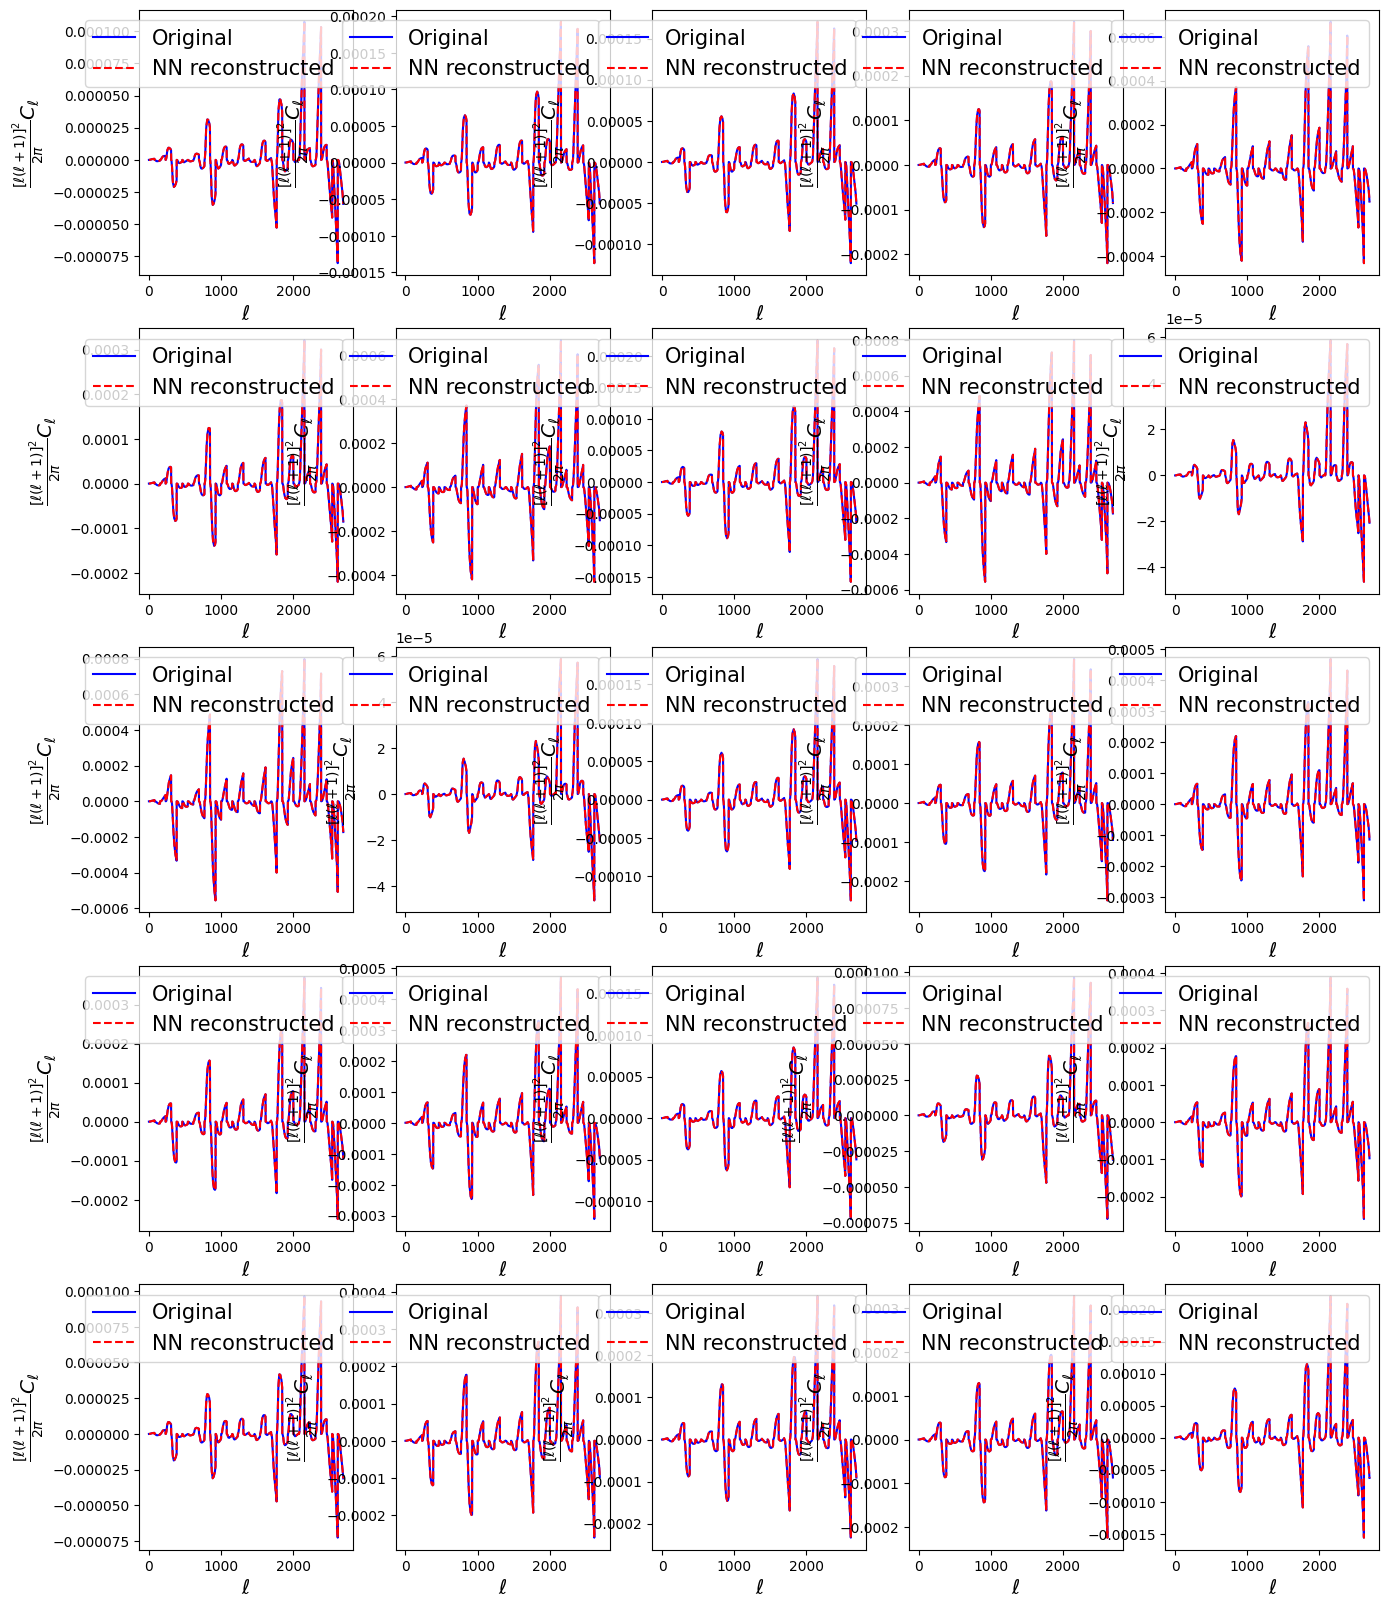

In [29]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(16,20))
for j in range(5):
    for i in range(5):
        pred = predicted_testing_spectra[i+j*3]
        true = testing_spectra[i+j*3]
        ell_range = np.arange(true.shape[0])
        ax[j, i].plot(ell_range, true, 'blue', label = 'Original')
        ax[j, i].plot(ell_range, pred, 'red', label = 'NN reconstructed', linestyle='--')
        ax[j, i].set_xlabel('$\ell$', fontsize='x-large')
        ax[j, i].set_ylabel('$\\frac{[\ell(\ell+1)]^2}{2 \pi} C_\ell$', fontsize='x-large')
        ax[j, i].legend(fontsize=15)


In [30]:
(1-np.median(np.abs((testing_spectra[:, ~zero_columns]-predicted_testing_spectra[:, ~zero_columns])/testing_spectra[:, ~zero_columns])))*100

99.96943268062263

In [31]:
(1-np.mean(np.abs((testing_spectra[:, ~zero_columns]-predicted_testing_spectra[:, ~zero_columns])/testing_spectra[:, ~zero_columns])))*100

99.73175127022907

In [32]:
# test_model.save("/cluster/work/refregier/alexree/local_packages/train_pybird_emulators/src/train_pybird_emulators/data/saved_models/ploopl_mono_80knots_newbank_emuinput_pca_finetuned")

In [33]:
weights_1 = "/cluster/work/refregier/alexree/local_packages/train_pybird_emulators/src/train_pybird_emulators/data/saved_models/ploopl_mono_80knots_newbank_emuinput_pca_finetuned_model_weights.pkl"
weights_2 = "/cluster/work/refregier/alexree/local_packages/train_pybird_emulators/src/train_pybird_emulators/data/saved_models/ploopl_mono_80knots_newbank_emuinput_pca_model_weights.pkl"

In [37]:
with open(weights_1, "rb") as f:
    dict_1 = pickle.load(f)

with open(weights_2, "rb") as f:
    dict_2 = pickle.load(f)

In [39]:
dict_1["weights_0"]

[array([[ 0.12924847,  0.10949043, -0.4536997 , ..., -0.04167202,
          0.40757418,  0.29589948],
        [-0.01390037,  0.1585152 , -0.3328291 , ..., -0.2477236 ,
         -0.03603904,  0.13640802],
        [-0.01843965,  0.01988511,  0.17313828, ..., -0.5029305 ,
         -0.10067203,  0.4870363 ],
        ...,
        [ 0.02459969,  0.07458375,  0.08522079, ...,  0.17097329,
         -0.19088507, -0.16404071],
        [-0.00211985, -0.18218318,  0.04710971, ..., -0.00884816,
          0.01321813, -0.02048729],
        [ 0.00284723,  0.02587845, -0.08617027, ...,  0.0098312 ,
         -0.20812565, -0.07127594]], dtype=float32),
 array([-6.79469928e-02, -3.32941450e-02, -1.02721892e-01, -1.58110764e-02,
        -8.23321939e-02, -1.41825587e-01, -4.79610145e-01, -1.92291886e-02,
        -3.68622859e-04,  1.77108273e-02,  2.53959466e-02, -1.67033821e-01,
        -7.70495608e-02,  7.76650190e-01, -4.87785973e-02, -5.82543612e-02,
         1.60285786e-01, -1.18026510e-02, -2.93728858e

In [ ]:
dict_1["weights_0"]